Neuroimaging cartesian reconstruction
=====================================
Author: Chaithya G R

In this tutorial we will reconstruct an MRI image from the sparse kspace
measurements.

Import neuroimaging data
------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice
and the cartesian acquisition scheme.

In [1]:
# Package import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
from pysap.data import get_sample_data
import pysap

# Third party import
import numpy as np
import matplotlib.pyplot as plt

/home/ciuciu/work/2020/1.Winter/20.01_ISMRM_WS/pysap-tutorials/demo/lib/python3.7/site-packages/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/ciuciu/work/2020/1.Winter/20.01_ISMRM_WS/pysap-tutorials/demo/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/ciuciu/work/2020/1.Winter/20.01_ISMRM_WS/pysap-tutorials/demo/lib/python3.7/site-packages/pysap/extensions/transform.py:41: UserWarning: Sparse2d python bindings not found, use binaries.
  warnings.warn("Sparse2d python bindings not found, use binaries.")


Loading input data and K-Space Cartesian Mask

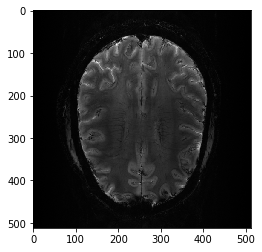

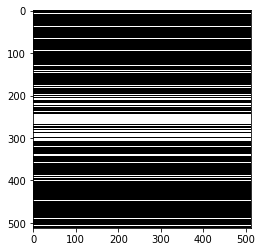

In [2]:
image = get_sample_data('2d-mri')
mask = get_sample_data("cartesian-mri-mask")
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------
From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [3]:
kspace_loc = convert_mask_to_locations(mask.data)
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

/home/ciuciu/work/2020/1.Winter/20.01_ISMRM_WS/pysap-tutorials/demo/lib/python3.7/site-packages/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


Zero Filled solution

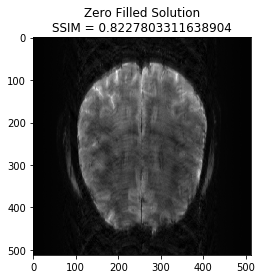

In [4]:
image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data),
                         metadata=image.metadata)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()

Setup Reconstruction Operators
------------------------------

Linear Operator : Symlet8 with 4 Scales

In [5]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)

Regularizer Operator : SparseThreshold ie L1 Norm. Lambda = 2e-7

In [6]:
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

Setup Single Channel Reconstructor

In [7]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1000000000000552
The lipschitz constraint is satisfied


FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost
Start Reconstruction

 - mu:  2e-07
 - lipschitz constant:  1.1000000000000552
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fe33bdf7810> - 4
 - max iterations:  100
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:21 Time:  0:00:21


 - final iteration number:  100
 - final log10 cost value:  -7.835120865857485
 - converged:  True
Done.
Execution time:  113.461906  seconds
----------------------------------------


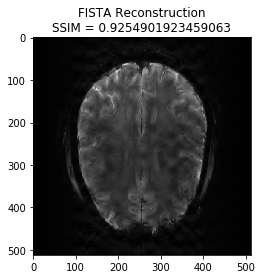

In [8]:
x_final, costs_fista, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

POGM optimization
------------------

We now want to refine the compare the convergence of FISTA with POGM algorithms
The cost function is set to Proximity Cost + Gradient Cost
Start Reconstruction

 - mu:  2e-07
 - lipschitz constant:  1.1000000000000552
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fe33bdf7810> - 4
 - max iterations:  100
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:22 Time:  0:00:22


 - final iteration number:  200
 - final log10 cost value:  -7.835132336766762
 - converged:  True
Done.
Execution time:  112.77097699999999  seconds
----------------------------------------


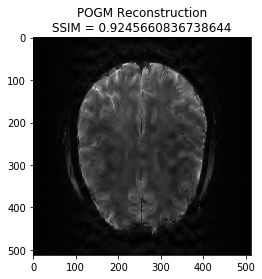

In [9]:
x_final_pogm, costs_pogm, metrics_pogm = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='pogm',
    num_iterations=100,
)

image_rec_pogm = pysap.Image(data=np.abs(x_final_pogm))
plt.imshow(np.abs(image_rec_pogm), cmap='gray')
recon_ssim_pogm = ssim(image_rec_pogm, image)
plt.title('POGM Reconstruction\nSSIM = ' + str(recon_ssim_pogm))
plt.show()


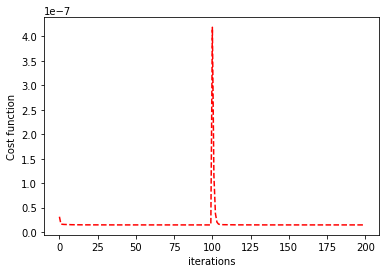

In [11]:
plt.plot(costs_pogm, 'r--', costs_fista, 'b--')
#plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Cost function')
plt.show()